# Trabajo 2: Aspectos prácticos de las redes neuronales

En este segundo trabajo, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [1]:
# Puedes añadir todos los imports adicionales que necesites aquí
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

/Users/sergiomunoz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Obtención de los datos y pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

#### **Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación **

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [3]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1**: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

### Estudio a priori Sigmoig Vs ReLUs
#### Ventajas:

* Sigmoid: Una de las ventajas que presenta Sigmoid es que, según los datos fluyen a través de la red, los pesos y los paráemtros ajustan estos valores, haciendo que los datos sean a veces demasiado grandes o demasiado pequeños. Esto se conoce como efecto "Blowing up Activation". En el caso de la sigmoid (también ocurre con Softmax) este efecto no se da, ya que la salida de esta función de activación está limitada a valores <1. 

* Relu : Las ReLUs no presentan problemas en el Backprogagation debido al efecto "vanishing gradient" que hace que los gradientes sean más pequeños al derivar de forma continuada, lo que hace que el valor del gradiente se aproxime a cero y por tanto llega un momento en que Backprograpation deja de funcionar

* Relu : Son mas feciciente desde el punto de vista computacional que la función Sigmoid ya que sus valores de salida son 0 si la entrada a la ReLU es <0 y 1, si es >0 al no realizar operaciones exponenciales como las Sigmoids

* Relu : En la práctica, las redes con ReLUs tienden a tener un rendimiento en convergencia mejor que las Sigmoid.


#### Desventajas:

* Sigmoid: Un efecto negativo de la Sigmoid es que tiende a hacer que el gradiente tienda a cero. Es lo que se conoce como " The Vanishing Gradient Problem". Ante incrementos de la entrada en la función sigmoid, el gradiente va disminuyendo tiendo a cero lo que origina problemas en Backpropagation. Este problema se agrava conforme el número de capas ocultas de la red se incrementa: a más capas, el producto de valores >1 tiende a cero rapidamente. De esta manera, lo que se ha demostrado como ventaja en Deep Learning -más capas, apriori, ayudan a tener mejor predicciones- se transforma con la función Sigmoid en algo tan negativo que hace que el paradigma del Deep Learning se venga abajo. Esto no courre con las ReLUs por los valores a la salida de la neurona (0 ó 1) que hace que este efecto de "vanishment"

* Relu : Tiende al efecto "Blow Activation"

* Relu : "Dying Relu", consistente en que si se dan muchas activaciones por debajo de cero, la mayor parte de las neuronas en la red tendrán como salida cero lo que origina que las neuronas mueran y la red no aprenda. Esto se puede evitar en cierta medida utilizando en lugar de ReLUs las Leaky-Relu.


In [4]:
## Tu código y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto

len(x_train)

60000

In [5]:
x_train.shape
#Hay 60.000 imagenes en el conjunto de test, cada una de las cuales, esta representada por 28x28 pixeles

(60000, 28, 28)

In [6]:
len(x_test)

10000

In [7]:
x_test.shape
#Hay 10.000 imagenes en el conjunto de test, cada una de las cuales, esta representada por 28x28 pixeles

(10000, 28, 28)

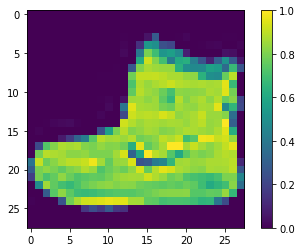

In [8]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
#Los datos se han de pre-procesar antes de realizar el entrenamiento.
#Si se realiza la inspeccción de la primera imagen del dataset, 
#se observa que los pixéles están dentro del rango etre 0 y 255.
#Al comiento, los dataset se han escalado entre 0 y 1 al dividir los valores de cada entrada por 255.
#De esta manera se puede alimentar la red neuronal.


In [9]:
#Del trabajo 1, tenemos el siguiente resultado de entrenamiento (con Sigmoid)

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.sigmoid),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.sigmoid),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Compilación del modelo
sgd = tf.train.GradientDescentOptimizer(0.001)
model.compile(optimizer=sgd, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
#Entrenamiento del modelo
hist_sigmoid = model.fit(x_train, y_train, batch_size=64, epochs=20,verbose=1,validation_data=(x_test,y_test))
print(hist_sigmoid.history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 21us/step - loss: 2.3883 - acc: 0.1035 - val_loss: 2.2916 - val_acc: 0.1485
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 2.3306 - acc: 0.1126 - val_loss: 2.2694 - val_acc: 0.2721
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.3102 - acc: 0.1219 - val_loss: 2.2501 - val_acc: 0.3432
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.2888 - acc: 0.1367 - val_loss: 2.2302 - val_acc: 0.4256
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.2686 - acc: 0.1506 - val_loss: 2.2095 - val_acc: 0.4647
Epoch 6/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.2472 - acc: 0.1642 - val_loss: 2.1875 - val_acc: 0.5056
Epoch 7/20
60000/60000 [==============================] - 1s 18us/step - loss: 2.2235 - acc: 0.1814 - val_loss: 2.1638 - val_acc

In [13]:

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
hist_ReLUs = model.fit(x_train, y_train, batch_size=64, epochs=20,verbose=1,validation_data=(x_test,y_test))
print(hist_ReLUs.history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.6193 - acc: 0.7823 - val_loss: 0.4616 - val_acc: 0.8270
Epoch 2/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.4355 - acc: 0.8430 - val_loss: 0.4022 - val_acc: 0.8554
Epoch 3/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.3957 - acc: 0.8569 - val_loss: 0.3830 - val_acc: 0.8629
Epoch 4/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.3728 - acc: 0.8640 - val_loss: 0.3669 - val_acc: 0.8667
Epoch 5/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.3573 - acc: 0.8689 - val_loss: 0.3633 - val_acc: 0.8699
Epoch 6/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.3403 - acc: 0.8753 - val_loss: 0.3702 - val_acc: 0.8651
Epoch 7/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.3295 - acc: 0.8781 - val_loss: 0.3609 - val_acc

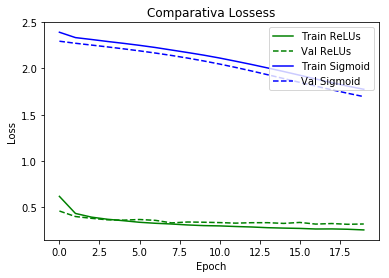

In [16]:
plot_compare_losses(hist_ReLUs, hist_sigmoid, name1="ReLUs",
                        name2="Sigmoid", title="Comparativa Lossess")

De la gráfica de Loss, se puede observar que el modelo sigmoid tiene un performance similar. De hecho, dado que comienzan a separarse casi desde el inicio ambas líneas y de forma consistente con respecto a la ejecución de las distintas épocas, se pude considerar como un indicio de que con menos épocas de entrenamiento para ese modelo, podríamos parar el entrenamiento.
En el caso de ReLUs, el performance es también similar y la separación entre líneas -que se vuelve consistente con el paso de las épocas - no indica que con 10 epocas aproximadamente, serí


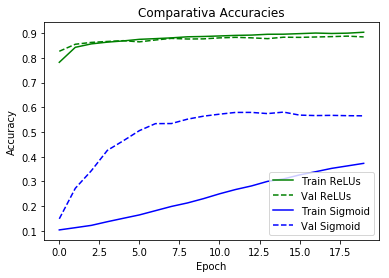

In [17]:
plot_compare_accs(hist_ReLUs, hist_sigmoid, name1="ReLUs",
                        name2="Sigmoid", title="Comparativa Accuracies")

En la gráfica de precisión podemos ver que el modelo ReLUs probablemente podría ser entrenado un poco más, ya que la tendencia de precisión sugiere  un aumento en las últimas épocas. También podemos ver que el modelo aún no ha aprendido demasiado sobre el conjunto de datos de entrenamiento.
En cambio, en el modelo Sigmoid, hay una gran diferencia y, aunque la tendencia es a converger, los efectos negativos de Sigmoid se aprecian ya en la gráfica.


## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2**: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

In [18]:
## Tu código y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para text

In [33]:
from keras.utils import np_utils
from keras.optimizers import SGD
#defino variables de configuración de la red
NB_EPOCH=25
BATCH_SIZE=128
VERBOSE=1
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
OPTIMIZER=tf.train.AdamOptimizer()

N_HIDDEN =128
VALIDATION_SPLIT=0.2 # cantidad del DataSet de train que se reserva para validación

In [34]:
print(x_train.shape[0],'train samples')

60000 train samples


In [35]:
print(x_test.shape[0],'train samples')

10000 train samples


In [37]:
#con inicializador aletorio normal
#Setup de las capas
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Compilo el modelo
model.compile(optimizer=OPTIMIZER, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
#Una vez que el modelo está compilado paso a entrenarlo con la función fit() en la que hay que escificar parámetros
#--> epochs: número de veces que el modelo se expone al conjunto de training. Por cada iteración (época)
#            el optimizador tratr de ajustar los pesos cpn el objetivo de minimizarlos
#-->batch_size: es el numero de instancias de traininig observadas antes de que el optmizador
#   realice una actualización de los pesos
history= model.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#se reserva parte del conjunto de training para validación. Con ésto, se reservan parte de los datos para realizar
#la evaluación del performances en la validación miestras se entrena. Esto ha de considerar como "Best prctices"

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 20us/step - loss: 0.6996 - acc: 0.7529 - val_loss: 0.4490 - val_acc: 0.8373
Epoch 2/25
48000/48000 [==============================] - 1s 14us/step - loss: 0.4591 - acc: 0.8375 - val_loss: 0.3958 - val_acc: 0.8580
Epoch 3/25
48000/48000 [==============================] - 1s 15us/step - loss: 0.4119 - acc: 0.8524 - val_loss: 0.3595 - val_acc: 0.8685
Epoch 4/25
48000/48000 [==============================] - 1s 14us/step - loss: 0.3840 - acc: 0.8607 - val_loss: 0.3651 - val_acc: 0.8715
Epoch 5/25
48000/48000 [==============================] - 1s 14us/step - loss: 0.3621 - acc: 0.8693 - val_loss: 0.3477 - val_acc: 0.8744
Epoch 6/25
48000/48000 [==============================] - 1s 14us/step - loss: 0.3473 - acc: 0.8740 - val_loss: 0.3348 - val_acc: 0.8812
Epoch 7/25
48000/48000 [==============================] - 1s 15us/step - loss: 0.3370 - acc: 0.8773 - val_loss: 0.3269 - val_acc

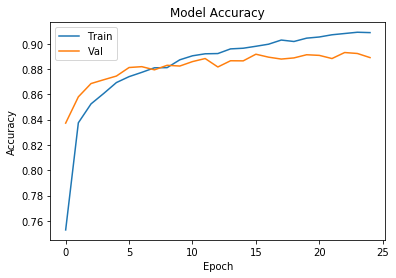

In [41]:
#muestro la accuracy del modelo
plot_acc(history, title="Model Accuracy")

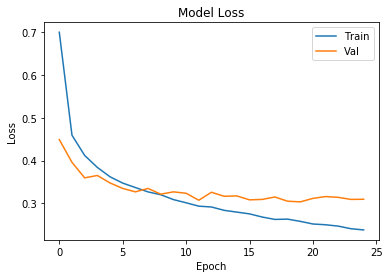

In [42]:
#muestro la loss del modelo
plot_loss(history, title="Model Loss")

In [44]:
score=model.evaluate(x_test,y_test,verbose=VERBOSE)
print("Test score:",score[0])
print("Test accuracy:",score[1])


10000/10000 [==============================] - 0s 17us/step
Test score: 0.33105758411884306
Test accuracy: 0.8863


#### Comparación de parametros con el inicializador de variable aleatoria
* Training:
    * Accuracy:90,87%
* Validación:
    * Accuracy:88,90%  
* Test: 
    * Accuracy:88,63%
    * Score:33,10%

In [47]:
#con inicializador zeros
#Setup de las capas
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer='zeros'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu,kernel_initializer='zeros'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [48]:
#Compilo el modelo
model1.compile(optimizer=OPTIMIZER, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
#entreno
history1= model1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 15us/step - loss: 2.3027 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.0983
Epoch 2/25
48000/48000 [==============================] - 1s 16us/step - loss: 2.3027 - acc: 0.0986 - val_loss: 2.3027 - val_acc: 0.0983
Epoch 3/25
48000/48000 [==============================] - 1s 15us/step - loss: 2.3027 - acc: 0.0988 - val_loss: 2.3027 - val_acc: 0.0958
Epoch 4/25
48000/48000 [==============================] - 1s 14us/step - loss: 2.3027 - acc: 0.0998 - val_loss: 2.3027 - val_acc: 0.0958
Epoch 5/25
48000/48000 [==============================] - 1s 14us/step - loss: 2.3027 - acc: 0.0970 - val_loss: 2.3027 - val_acc: 0.0958
Epoch 6/25
48000/48000 [==============================] - 1s 14us/step - loss: 2.3027 - acc: 0.0984 - val_loss: 2.3028 - val_acc: 0.0958
Epoch 7/25
48000/48000 [==============================] - 1s 15us/step - loss: 2.3027 - acc: 0.0992 - val_loss: 2.3027 - val_acc

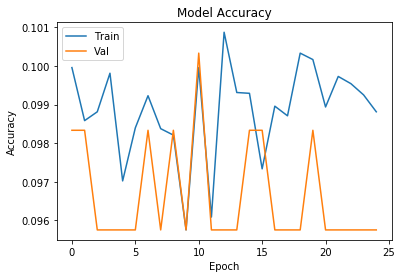

In [51]:
#muestro la accuracy del modelo
plot_acc(history1, title="Model Accuracy")

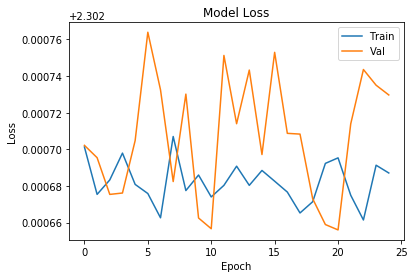

In [52]:
#muestro la loss del modelo
plot_loss(history1, title="Model Loss")

In [54]:
score1=model1.evaluate(x_test,y_test,verbose=VERBOSE)
print("Test score:",score[0])
print("Test accuracy:",score[1])


10000/10000 [==============================] - 0s 17us/step
Test score: 0.33105758411884306
Test accuracy: 0.8863


#### Comparación de parametros con el inicializador de zeros
* Training:
    * Accuracy:9,88%
* Validación:
    * Accuracy:9,58%  
* Test: 
    * Accuracy:88,63%
    * Score:33,10%

In [55]:
#con inicializador aletorio normal
#Setup de las capas
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer='glorot_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu,kernel_initializer='glorot_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [56]:
#Compilo el modelo
model2.compile(optimizer=OPTIMIZER, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
#entreno
history2= model2.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 22us/step - loss: 0.5947 - acc: 0.7845 - val_loss: 0.4134 - val_acc: 0.8463
Epoch 2/25
48000/48000 [==============================] - 1s 15us/step - loss: 0.4338 - acc: 0.8442 - val_loss: 0.3865 - val_acc: 0.8582
Epoch 3/25
48000/48000 [==============================] - 1s 15us/step - loss: 0.3935 - acc: 0.8578 - val_loss: 0.3681 - val_acc: 0.8662
Epoch 4/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.3739 - acc: 0.8641 - val_loss: 0.3615 - val_acc: 0.8675
Epoch 5/25
48000/48000 [==============================] - 1s 17us/step - loss: 0.3591 - acc: 0.8703 - val_loss: 0.3417 - val_acc: 0.8744
Epoch 6/25
48000/48000 [==============================] - 1s 16us/step - loss: 0.3439 - acc: 0.8737 - val_loss: 0.3344 - val_acc: 0.8782
Epoch 7/25
48000/48000 [==============================] - 1s 16us/step - loss: 0.3348 - acc: 0.8780 - val_loss: 0.3312 - val_acc

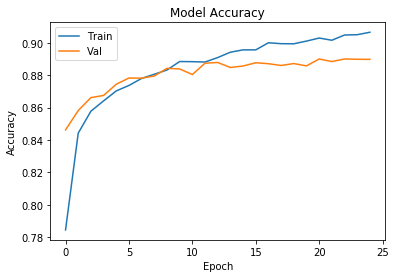

In [58]:
#muestro la accuracy del modelo
plot_acc(history2, title="Model Accuracy")

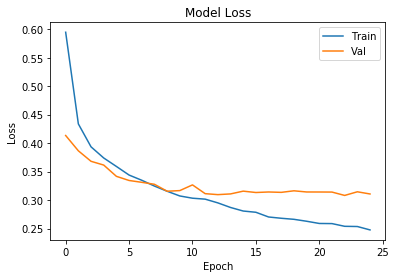

In [59]:
#muestro la loss del modelo
plot_loss(history2, title="Model Loss")

In [60]:
score2=model2.evaluate(x_test,y_test,verbose=VERBOSE)
print("Test score:",score[0])
print("Test accuracy:",score[1])


10000/10000 [==============================] - 0s 17us/step
Test score: 0.33105758411884306
Test accuracy: 0.8863


#### Comparación de parametros con el inicializador glorot_uniform
* Training:
    * Accuracy:90,65%
* Validación:
    * Accuracy:88,97% 
* Test: 
    * Accuracy:88,63%
    * Score:33,10%

#### Comparando los tres modelos:
--> Random
    * Acc Training:90,87%
    * Acc Val:88,90%
    * Acc Test:88,63%
--> Zeros
    * Acc Training: 9,58%
    * Acc Val: 9,58%
    * Acc Test: 88,63%
--> glorot_uniform
    * Acc Training:90,65%
    * Acc Val: 88,97%
    * Acc Test: 88,63%
El que mejor comportamiento tiene es el inicializador de tipo random.

## 3. Optimizadores

**Ejercicio 3**: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

In [76]:
##Stochastic gradient descent optimizer.
OPTIMEZER1=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
#Includes support for momentum, learning rate decay, and Nesterov momentum
#Arguments
#lr: float >= 0. Learning rate.
#momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
#decay: float >= 0. Learning rate decay over each update.
#Nesterov: boolean. Whether to apply Nesterov momentum.


#Adam optimizer
OPTIMIZER2=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#Default parameters follow those provided in the original paper.
#Arguments
#
#lr: float >= 0. Learning rate.
#beta_1: float, 0 < beta < 1. Generally close to 1.
#beta_2: float, 0 < beta < 1. Generally close to 1.
#epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
#decay: float >= 0. Learning rate decay over each update.
#amsgrad: boolean. Whether to apply the AMSGrad variant of this algorithm from the paper "On the Convergence of Adam and Beyond".

#RMSProp optimizer.
OPTIMIZER3=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#It is recommended to leave the parameters of this optimizer at their default values (except the learning rate, which can be freely tuned).
#This optimizer is usually a good choice for recurrent neural networks.
#Arguments
#
#lr: float >= 0. Learning rate.
#rho: float >= 0.
#epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
#decay: float >= 0. Learning rate decay over each update.

In [77]:
#A apartir del inicializador de random

In [ ]:
#OPTMIZADOR SGD

In [78]:
model_SGD = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_SGD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [79]:
#Compilo el modelo
model_SGD.compile(optimizer=OPTIMIZER1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
#entreno
history_SGD= model_SGD.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 25us/step - loss: 0.6901 - acc: 0.7587 - val_loss: 0.4392 - val_acc: 0.8423
Epoch 2/25
48000/48000 [==============================] - 1s 15us/step - loss: 0.4512 - acc: 0.8372 - val_loss: 0.3910 - val_acc: 0.8565
Epoch 3/25
48000/48000 [==============================] - 1s 16us/step - loss: 0.4025 - acc: 0.8556 - val_loss: 0.3687 - val_acc: 0.8645
Epoch 4/25
48000/48000 [==============================] - 1s 20us/step - loss: 0.3828 - acc: 0.8618 - val_loss: 0.3541 - val_acc: 0.8719
Epoch 5/25
48000/48000 [==============================] - 1s 16us/step - loss: 0.3620 - acc: 0.8700 - val_loss: 0.3432 - val_acc: 0.8761
Epoch 6/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.3454 - acc: 0.8744 - val_loss: 0.3365 - val_acc: 0.8802
Epoch 7/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.3330 - acc: 0.8776 - val_loss: 0.3247 - val_acc

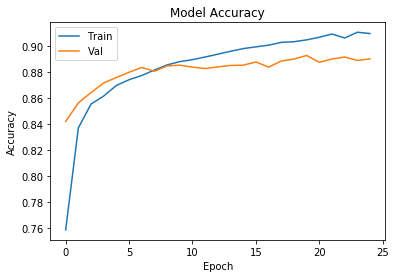

In [81]:
#muestro la accuracy del modelo
plot_acc(history_SGD, title="Model Accuracy")

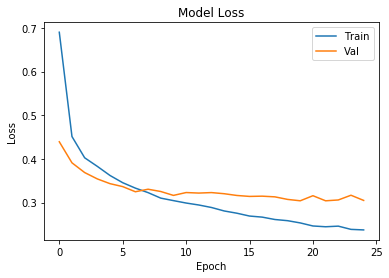

In [82]:
#muestro la loss del modelo
plot_loss(history_SGD, title="Model Loss")

In [83]:
score_SGD=model_SGD.evaluate(x_test,y_test,verbose=VERBOSE)
print("Test score:",score[0])
print("Test accuracy:",score[1])

10000/10000 [==============================] - 0s 18us/step
Test score: 0.33105758411884306
Test accuracy: 0.8863


In [ ]:
#OPTMIZADOR ADAM

In [91]:
model_ADAM = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_ADAM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [85]:
#Compilo el modelo
model_ADAM.compile(optimizer=OPTIMIZER2, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [86]:
#entreno
history_ADAM= model_ADAM.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 28us/step - loss: 0.7015 - acc: 0.7471 - val_loss: 0.4496 - val_acc: 0.8379
Epoch 2/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.4569 - acc: 0.8392 - val_loss: 0.3914 - val_acc: 0.8608
Epoch 3/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.4103 - acc: 0.8525 - val_loss: 0.3828 - val_acc: 0.8626
Epoch 4/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.3804 - acc: 0.8635 - val_loss: 0.3527 - val_acc: 0.8744
Epoch 5/25
48000/48000 [==============================] - 1s 20us/step - loss: 0.3598 - acc: 0.8705 - val_loss: 0.3461 - val_acc: 0.8776
Epoch 6/25
48000/48000 [==============================] - 1s 24us/step - loss: 0.3483 - acc: 0.8725 - val_loss: 0.3411 - val_acc: 0.8774
Epoch 7/25
48000/48000 [==============================] - 1s 21us/step - loss: 0.3368 - acc: 0.8768 - val_loss: 0.3387 - val_acc

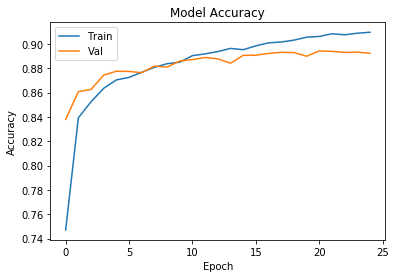

In [87]:
#muestro la accuracy del modelo
plot_acc(history_ADAM, title="Model Accuracy")

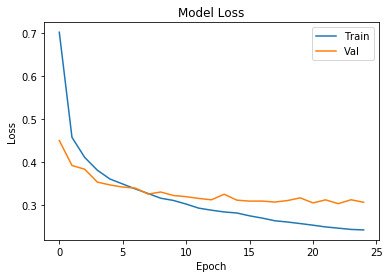

In [88]:
#muestro la loss del modelo
plot_loss(history_ADAM, title="Model Loss")

In [89]:
score_ADAM=model_ADAM.evaluate(x_test,y_test,verbose=VERBOSE)
print("Test score:",score[0])
print("Test accuracy:",score[1])

10000/10000 [==============================] - 0s 20us/step
Test score: 0.33105758411884306
Test accuracy: 0.8863


In [92]:
#OPTMIZADOR RMSProp

In [95]:
model_RMSprop = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
model_RMSprop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [96]:
#Compilo el modelo
model_RMSprop.compile(optimizer=OPTIMIZER3, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
#entreno
history_RMSprop= model_RMSprop.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 1s 27us/step - loss: 0.6805 - acc: 0.7596 - val_loss: 0.4603 - val_acc: 0.8347
Epoch 2/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.4602 - acc: 0.8350 - val_loss: 0.3935 - val_acc: 0.8552
Epoch 3/25
48000/48000 [==============================] - 1s 18us/step - loss: 0.4094 - acc: 0.8526 - val_loss: 0.3802 - val_acc: 0.8559
Epoch 4/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.3846 - acc: 0.8597 - val_loss: 0.3602 - val_acc: 0.8686
Epoch 5/25
48000/48000 [==============================] - 1s 23us/step - loss: 0.3658 - acc: 0.8669 - val_loss: 0.3517 - val_acc: 0.8740
Epoch 6/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.3494 - acc: 0.8714 - val_loss: 0.3384 - val_acc: 0.8788
Epoch 7/25
48000/48000 [==============================] - 1s 19us/step - loss: 0.3409 - acc: 0.8769 - val_loss: 0.3362 - val_acc

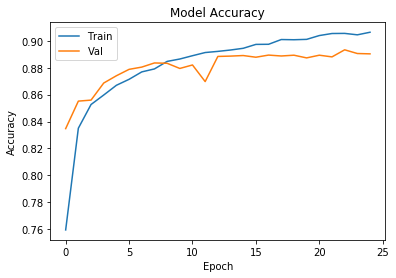

In [98]:
#muestro la accuracy del modelo
plot_acc(history_RMSprop, title="Model Accuracy")

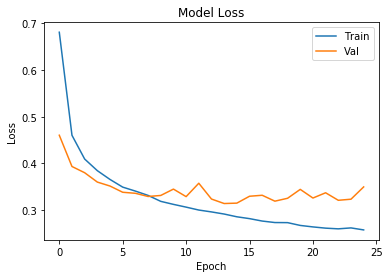

In [99]:
#muestro la loss del modelo
plot_loss(history_RMSprop, title="Model Loss")

In [100]:
score_RMSprop=model_RMSprop.evaluate(x_test,y_test,verbose=VERBOSE)
print("Test score:",score[0])
print("Test accuracy:",score[1])

10000/10000 [==============================] - 0s 19us/step
Test score: 0.33105758411884306
Test accuracy: 0.8863


#### Comparando los tres modelos:
--> SGD
    * Acc Training:91% 
    * Acc Val:89,04%
    * Acc Test:88,63%
--> Adam
    * Acc Training: 90,96% 
    * Acc Val: 89,24%
    * Acc Test: 88,63%%
--> RMSprop
    * Acc Training:90,63%  
    * Acc Val: 89,03%
    * Acc Test: 88,63%
El que mejor comportamiento tiene es el inicializador de tipo random.

## 4. Regularización y red final

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

In [ ]:
## Tu modelo y comentarios de texto aquí
## No olvides utilizar celdas de Markdown para texto

In [105]:

#valido contra distintos valores de Dropout
DROPOUT1=0.1
DROPOUT2=0.2
DROPOUT3=0.3
#INCREMENTO EL NUMERO DE EPOCAS
NB_EPOCH=250
#INCREMENTO EL NUMERO DE CELDAS POR CADA
N_HIDDEN=128
#MANTENGO EL SPLIT DE VALIDACIÓN
BATCH_SIZE=128
NB_CLASSES=10


In [106]:
#Parto del optimizador SGS y el inicializador random
model_final1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT1),
    keras.layers.Dense(N_HIDDEN,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT1),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [107]:
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final1.compile(optimizer=OPTIMIZER1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [108]:
#entreno
history_final1= model_final1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/250
48000/48000 [==============================] - 1s 27us/step - loss: 0.5321 - acc: 0.8047 - val_loss: 0.4061 - val_acc: 0.8498
Epoch 2/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.3865 - acc: 0.8583 - val_loss: 0.3699 - val_acc: 0.8620
Epoch 3/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.3523 - acc: 0.8717 - val_loss: 0.3508 - val_acc: 0.8737
Epoch 4/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3319 - acc: 0.8770 - val_loss: 0.3305 - val_acc: 0.8815
Epoch 5/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.3124 - acc: 0.8835 - val_loss: 0.3307 - val_acc: 0.8823
Epoch 6/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.3035 - acc: 0.8881 - val_loss: 0.3311 - val_acc: 0.8808
Epoch 7/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.2918 - acc: 0.8918 - val_loss: 0.3180 - 

48000/48000 [==============================] - 1s 18us/step - loss: 0.1298 - acc: 0.9511 - val_loss: 0.3624 - val_acc: 0.8933
Epoch 60/250
48000/48000 [==============================] - 1s 22us/step - loss: 0.1363 - acc: 0.9485 - val_loss: 0.3636 - val_acc: 0.8948
Epoch 61/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1324 - acc: 0.9512 - val_loss: 0.3748 - val_acc: 0.8944
Epoch 62/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.1311 - acc: 0.9513 - val_loss: 0.3652 - val_acc: 0.8972
Epoch 63/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1310 - acc: 0.9499 - val_loss: 0.3701 - val_acc: 0.8935
Epoch 64/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.1318 - acc: 0.9497 - val_loss: 0.3532 - val_acc: 0.8966
Epoch 65/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.1313 - acc: 0.9513 - val_loss: 0.3751 - val_acc: 0.8942
Epoch 66/250
48000/48000 [==============

Epoch 118/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.0936 - acc: 0.9644 - val_loss: 0.4341 - val_acc: 0.8936
Epoch 119/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.0937 - acc: 0.9641 - val_loss: 0.4620 - val_acc: 0.8935
Epoch 120/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.0950 - acc: 0.9636 - val_loss: 0.4648 - val_acc: 0.8948
Epoch 121/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.0911 - acc: 0.9657 - val_loss: 0.4673 - val_acc: 0.8912
Epoch 122/250
48000/48000 [==============================] - 1s 23us/step - loss: 0.0939 - acc: 0.9645 - val_loss: 0.4544 - val_acc: 0.8888
Epoch 123/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.0895 - acc: 0.9665 - val_loss: 0.4503 - val_acc: 0.8930
Epoch 124/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.0926 - acc: 0.9661 - val_loss: 0.4588 - val_acc: 0.8925
Epoch 125/250
48000/

48000/48000 [==============================] - 1s 18us/step - loss: 0.0766 - acc: 0.9716 - val_loss: 0.5043 - val_acc: 0.8936
Epoch 177/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.0756 - acc: 0.9721 - val_loss: 0.5157 - val_acc: 0.8948
Epoch 178/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.0749 - acc: 0.9726 - val_loss: 0.4924 - val_acc: 0.8948
Epoch 179/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.0757 - acc: 0.9727 - val_loss: 0.4957 - val_acc: 0.8919
Epoch 180/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.0773 - acc: 0.9713 - val_loss: 0.5029 - val_acc: 0.8926
Epoch 181/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.0734 - acc: 0.9728 - val_loss: 0.4892 - val_acc: 0.8928
Epoch 182/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.0726 - acc: 0.9736 - val_loss: 0.5192 - val_acc: 0.8919
Epoch 183/250
48000/48000 [=======

48000/48000 [==============================] - 1s 18us/step - loss: 0.0709 - acc: 0.9746 - val_loss: 0.5297 - val_acc: 0.8888
Epoch 235/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.0601 - acc: 0.9778 - val_loss: 0.5526 - val_acc: 0.8938
Epoch 236/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.0658 - acc: 0.9764 - val_loss: 0.5402 - val_acc: 0.8926
Epoch 237/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.0665 - acc: 0.9758 - val_loss: 0.5260 - val_acc: 0.8912
Epoch 238/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.0635 - acc: 0.9767 - val_loss: 0.5402 - val_acc: 0.8938
Epoch 239/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.0642 - acc: 0.9777 - val_loss: 0.5517 - val_acc: 0.8903
Epoch 240/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.0689 - acc: 0.9754 - val_loss: 0.5268 - val_acc: 0.8915
Epoch 241/250
48000/48000 [=======

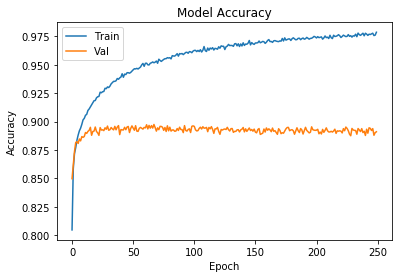

In [109]:
#muestro la accuracy del modelo
plot_acc(history_final1, title="Model Accuracy")

In [110]:
#incremento el dropout
#Parto del optimizador SGS y el inicializador random
model_final2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [111]:
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final2.compile(optimizer=OPTIMIZER1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [112]:
history_final2= model_final2.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 48000 samples, validate on 12000 samples
Epoch 1/250
48000/48000 [==============================] - 1s 28us/step - loss: 0.5690 - acc: 0.7920 - val_loss: 0.4086 - val_acc: 0.8461
Epoch 2/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.4122 - acc: 0.8511 - val_loss: 0.3844 - val_acc: 0.8628
Epoch 3/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3804 - acc: 0.8611 - val_loss: 0.3723 - val_acc: 0.8651
Epoch 4/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.3617 - acc: 0.8671 - val_loss: 0.3497 - val_acc: 0.8727
Epoch 5/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.3432 - acc: 0.8735 - val_loss: 0.3400 - val_acc: 0.8767
Epoch 6/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3316 - acc: 0.8783 - val_loss: 0.3341 - val_acc: 0.8797
Epoch 7/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3189 - acc: 0.8821 - val_loss: 0.3313 - 

48000/48000 [==============================] - 1s 18us/step - loss: 0.1848 - acc: 0.9301 - val_loss: 0.3331 - val_acc: 0.8945
Epoch 60/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1895 - acc: 0.9279 - val_loss: 0.3427 - val_acc: 0.8918
Epoch 61/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1851 - acc: 0.9303 - val_loss: 0.3276 - val_acc: 0.8956
Epoch 62/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1852 - acc: 0.9301 - val_loss: 0.3311 - val_acc: 0.8930
Epoch 63/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1864 - acc: 0.9299 - val_loss: 0.3322 - val_acc: 0.8935
Epoch 64/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1826 - acc: 0.9312 - val_loss: 0.3459 - val_acc: 0.8934
Epoch 65/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1799 - acc: 0.9319 - val_loss: 0.3394 - val_acc: 0.8922
Epoch 66/250
48000/48000 [==============

Epoch 118/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1448 - acc: 0.9454 - val_loss: 0.3807 - val_acc: 0.8931
Epoch 119/250
48000/48000 [==============================] - 1s 23us/step - loss: 0.1487 - acc: 0.9445 - val_loss: 0.3760 - val_acc: 0.8908
Epoch 120/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1496 - acc: 0.9431 - val_loss: 0.3813 - val_acc: 0.8910
Epoch 121/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1469 - acc: 0.9448 - val_loss: 0.3785 - val_acc: 0.8930
Epoch 122/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1486 - acc: 0.9444 - val_loss: 0.3691 - val_acc: 0.8917
Epoch 123/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1481 - acc: 0.9439 - val_loss: 0.3773 - val_acc: 0.8940
Epoch 124/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1472 - acc: 0.9450 - val_loss: 0.3820 - val_acc: 0.8888
Epoch 125/250
48000/

48000/48000 [==============================] - 1s 17us/step - loss: 0.1257 - acc: 0.9523 - val_loss: 0.4229 - val_acc: 0.8913
Epoch 177/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1293 - acc: 0.9507 - val_loss: 0.4090 - val_acc: 0.8920
Epoch 178/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1239 - acc: 0.9550 - val_loss: 0.4172 - val_acc: 0.8901
Epoch 179/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1289 - acc: 0.9514 - val_loss: 0.4055 - val_acc: 0.8915
Epoch 180/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1255 - acc: 0.9541 - val_loss: 0.4203 - val_acc: 0.8912
Epoch 181/250
48000/48000 [==============================] - 1s 22us/step - loss: 0.1287 - acc: 0.9512 - val_loss: 0.4373 - val_acc: 0.8881
Epoch 182/250
48000/48000 [==============================] - 1s 23us/step - loss: 0.1254 - acc: 0.9530 - val_loss: 0.4149 - val_acc: 0.8951
Epoch 183/250
48000/48000 [=======

48000/48000 [==============================] - 1s 19us/step - loss: 0.1149 - acc: 0.9568 - val_loss: 0.4438 - val_acc: 0.8920
Epoch 235/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.1137 - acc: 0.9587 - val_loss: 0.4531 - val_acc: 0.8904
Epoch 236/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1137 - acc: 0.9579 - val_loss: 0.4566 - val_acc: 0.8895
Epoch 237/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.1155 - acc: 0.9577 - val_loss: 0.4606 - val_acc: 0.8896
Epoch 238/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.1120 - acc: 0.9577 - val_loss: 0.4777 - val_acc: 0.8894
Epoch 239/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1117 - acc: 0.9589 - val_loss: 0.4739 - val_acc: 0.8876
Epoch 240/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.1131 - acc: 0.9590 - val_loss: 0.4830 - val_acc: 0.8894
Epoch 241/250
48000/48000 [=======

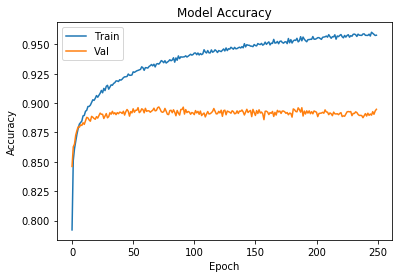

In [115]:
#muestro la accuracy del modelo
plot_acc(history_final2, title="Model Accuracy")

In [114]:
#incremento el dropout
#Parto del optimizador SGS y el inicializador random
model_final3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT3),
    keras.layers.Dense(N_HIDDEN,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT3),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final3.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final3.compile(optimizer=OPTIMIZER1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final3= model_final3.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 1s 18us/step - loss: 0.2440 - acc: 0.9076 - val_loss: 0.3210 - val_acc: 0.8933
Epoch 52/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.2451 - acc: 0.9067 - val_loss: 0.3196 - val_acc: 0.8909
Epoch 53/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.2420 - acc: 0.9093 - val_loss: 0.3262 - val_acc: 0.8905
Epoch 54/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2437 - acc: 0.9086 - val_loss: 0.3180 - val_acc: 0.8921
Epoch 55/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.2413 - acc: 0.9095 - val_loss: 0.3219 - val_acc: 0.8915
Epoch 56/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2409 - acc: 0.9089 - val_loss: 0.3235 - val_acc: 0.8911
Epoch 57/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2358 - acc: 0.9119 - val_loss: 0.3281 - val_acc: 0.8900
Epoch 58/250
48000/48000 [==============

Epoch 110/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2041 - acc: 0.9237 - val_loss: 0.3521 - val_acc: 0.8940
Epoch 111/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2057 - acc: 0.9221 - val_loss: 0.3557 - val_acc: 0.8924
Epoch 112/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2016 - acc: 0.9236 - val_loss: 0.3538 - val_acc: 0.8953
Epoch 113/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.2037 - acc: 0.9239 - val_loss: 0.3500 - val_acc: 0.8918
Epoch 114/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2022 - acc: 0.9243 - val_loss: 0.3490 - val_acc: 0.8905
Epoch 115/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1985 - acc: 0.9247 - val_loss: 0.3451 - val_acc: 0.8929
Epoch 116/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2005 - acc: 0.9229 - val_loss: 0.3606 - val_acc: 0.8893
Epoch 117/250
48000/

48000/48000 [==============================] - 1s 18us/step - loss: 0.1760 - acc: 0.9334 - val_loss: 0.3921 - val_acc: 0.8905
Epoch 169/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1788 - acc: 0.9337 - val_loss: 0.3814 - val_acc: 0.8903
Epoch 170/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1813 - acc: 0.9318 - val_loss: 0.3958 - val_acc: 0.8894
Epoch 171/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1770 - acc: 0.9330 - val_loss: 0.3910 - val_acc: 0.8896
Epoch 172/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1788 - acc: 0.9317 - val_loss: 0.3982 - val_acc: 0.8896
Epoch 173/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1793 - acc: 0.9325 - val_loss: 0.3788 - val_acc: 0.8902
Epoch 174/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.1779 - acc: 0.9331 - val_loss: 0.3968 - val_acc: 0.8911
Epoch 175/250
48000/48000 [=======

48000/48000 [==============================] - 1s 18us/step - loss: 0.1670 - acc: 0.9382 - val_loss: 0.4065 - val_acc: 0.8918
Epoch 227/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1685 - acc: 0.9370 - val_loss: 0.4194 - val_acc: 0.8918
Epoch 228/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1670 - acc: 0.9362 - val_loss: 0.4260 - val_acc: 0.8923
Epoch 229/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1633 - acc: 0.9381 - val_loss: 0.4310 - val_acc: 0.8907
Epoch 230/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1684 - acc: 0.9371 - val_loss: 0.4072 - val_acc: 0.8926
Epoch 231/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.1613 - acc: 0.9380 - val_loss: 0.4295 - val_acc: 0.8909
Epoch 232/250
48000/48000 [==============================] - 1s 17us/step - loss: 0.1637 - acc: 0.9378 - val_loss: 0.4186 - val_acc: 0.8918
Epoch 233/250
48000/48000 [=======

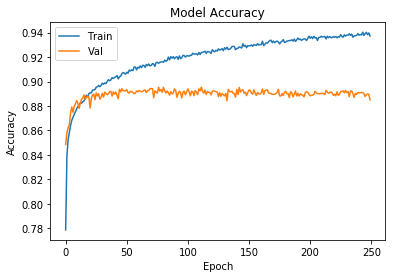

In [116]:
#muestro la accuracy del modelo
plot_acc(history_final3, title="Model Accuracy")

#### Accuracy Vs Dropout
* dropout=0,1% - accuracy val:89,10
* dropout=0,2% - accuracy val:89,48 --> me quedo con este modelo y trato de mejorarlo con otros parámetros.
* dropout=0,3% - accuracy val:88,5%

In [126]:
#modificación del learning rate
OPTIMIZER_LR1=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
OPTIMIZER_LR2=keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
OPTIMIZER_LR3=keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_22 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_43 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 1s 19us/step - loss: 0.3678 - acc: 0.8686 - val_loss: 0.3600 - val_acc: 0.8694
Epoch 52/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.3638 - acc: 0.8711 - val_loss: 0.3562 - val_acc: 0.8703
Epoch 53/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3648 - acc: 0.8713 - val_loss: 0.3551 - val_acc: 0.8721
Epoch 54/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.3632 - acc: 0.8711 - val_loss: 0.3528 - val_acc: 0.8718
Epoch 55/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3608 - acc: 0.8718 - val_loss: 0.3520 - val_acc: 0.8730
Epoch 56/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.3577 - acc: 0.8732 - val_loss: 0.3506 - val_acc: 0.8726
Epoch 57/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.3559 - acc: 0.8741 - val_loss: 0.3495 - val_acc: 0.8726
Epoch 58/250
48000/48000 [==============

Epoch 110/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2957 - acc: 0.8940 - val_loss: 0.3154 - val_acc: 0.8874
Epoch 111/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.2941 - acc: 0.8962 - val_loss: 0.3162 - val_acc: 0.8864
Epoch 112/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2951 - acc: 0.8945 - val_loss: 0.3146 - val_acc: 0.8871
Epoch 113/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.2942 - acc: 0.8950 - val_loss: 0.3140 - val_acc: 0.8879
Epoch 114/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2916 - acc: 0.8943 - val_loss: 0.3141 - val_acc: 0.8896
Epoch 115/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2910 - acc: 0.8952 - val_loss: 0.3150 - val_acc: 0.8870
Epoch 116/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2902 - acc: 0.8971 - val_loss: 0.3131 - val_acc: 0.8885
Epoch 117/250
48000/

48000/48000 [==============================] - 1s 19us/step - loss: 0.2515 - acc: 0.9090 - val_loss: 0.3030 - val_acc: 0.8922
Epoch 169/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2503 - acc: 0.9095 - val_loss: 0.3021 - val_acc: 0.8927
Epoch 170/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2493 - acc: 0.9097 - val_loss: 0.3022 - val_acc: 0.8938
Epoch 171/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2498 - acc: 0.9095 - val_loss: 0.3024 - val_acc: 0.8932
Epoch 172/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.2470 - acc: 0.9111 - val_loss: 0.3040 - val_acc: 0.8922
Epoch 173/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2481 - acc: 0.9101 - val_loss: 0.3005 - val_acc: 0.8918
Epoch 174/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.2467 - acc: 0.9128 - val_loss: 0.3030 - val_acc: 0.8914
Epoch 175/250
48000/48000 [=======

48000/48000 [==============================] - 1s 19us/step - loss: 0.2153 - acc: 0.9220 - val_loss: 0.2994 - val_acc: 0.8950
Epoch 227/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2181 - acc: 0.9214 - val_loss: 0.3015 - val_acc: 0.8923
Epoch 228/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2164 - acc: 0.9219 - val_loss: 0.3000 - val_acc: 0.8944
Epoch 229/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.2179 - acc: 0.9223 - val_loss: 0.2972 - val_acc: 0.8950
Epoch 230/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.2175 - acc: 0.9224 - val_loss: 0.3020 - val_acc: 0.8942
Epoch 231/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2176 - acc: 0.9207 - val_loss: 0.2994 - val_acc: 0.8952
Epoch 232/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.2154 - acc: 0.9229 - val_loss: 0.2993 - val_acc: 0.8937
Epoch 233/250
48000/48000 [=======

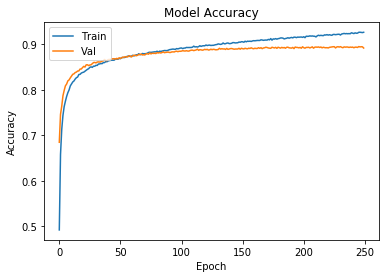

In [123]:
#incremento el dropout
#Parto del optimizador SGS y el inicializador random
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_45 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 1s 20us/step - loss: 1.4666 - acc: 0.5293 - val_loss: 1.3617 - val_acc: 0.6395
Epoch 52/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.4551 - acc: 0.5313 - val_loss: 1.3489 - val_acc: 0.6422
Epoch 53/250
48000/48000 [==============================] - 1s 19us/step - loss: 1.4405 - acc: 0.5379 - val_loss: 1.3364 - val_acc: 0.6447
Epoch 54/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.4321 - acc: 0.5392 - val_loss: 1.3241 - val_acc: 0.6457
Epoch 55/250
48000/48000 [==============================] - 1s 22us/step - loss: 1.4189 - acc: 0.5453 - val_loss: 1.3122 - val_acc: 0.6466
Epoch 56/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.4088 - acc: 0.5446 - val_loss: 1.3004 - val_acc: 0.6481
Epoch 57/250
48000/48000 [==============================] - 1s 21us/step - loss: 1.4022 - acc: 0.5470 - val_loss: 1.2889 - val_acc: 0.6491
Epoch 58/250
48000/48000 [==============

Epoch 110/250
48000/48000 [==============================] - 1s 23us/step - loss: 1.0625 - acc: 0.6223 - val_loss: 0.9329 - val_acc: 0.6877
Epoch 111/250
48000/48000 [==============================] - 1s 21us/step - loss: 1.0558 - acc: 0.6245 - val_loss: 0.9293 - val_acc: 0.6886
Epoch 112/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.0526 - acc: 0.6278 - val_loss: 0.9258 - val_acc: 0.6893
Epoch 113/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.0498 - acc: 0.6273 - val_loss: 0.9223 - val_acc: 0.6900
Epoch 114/250
48000/48000 [==============================] - 1s 21us/step - loss: 1.0466 - acc: 0.6292 - val_loss: 0.9189 - val_acc: 0.6906
Epoch 115/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.0439 - acc: 0.6301 - val_loss: 0.9156 - val_acc: 0.6913
Epoch 116/250
48000/48000 [==============================] - 1s 20us/step - loss: 1.0391 - acc: 0.6314 - val_loss: 0.9124 - val_acc: 0.6922
Epoch 117/250
48000/

48000/48000 [==============================] - 1s 21us/step - loss: 0.9123 - acc: 0.6689 - val_loss: 0.7972 - val_acc: 0.7211
Epoch 169/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.9085 - acc: 0.6709 - val_loss: 0.7956 - val_acc: 0.7217
Epoch 170/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.9072 - acc: 0.6716 - val_loss: 0.7941 - val_acc: 0.7220
Epoch 171/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.9073 - acc: 0.6715 - val_loss: 0.7926 - val_acc: 0.7223
Epoch 172/250
48000/48000 [==============================] - 1s 22us/step - loss: 0.9070 - acc: 0.6714 - val_loss: 0.7911 - val_acc: 0.7223
Epoch 173/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.9041 - acc: 0.6749 - val_loss: 0.7897 - val_acc: 0.7226
Epoch 174/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.9030 - acc: 0.6734 - val_loss: 0.7882 - val_acc: 0.7232
Epoch 175/250
48000/48000 [=======

48000/48000 [==============================] - 1s 21us/step - loss: 0.8339 - acc: 0.7019 - val_loss: 0.7282 - val_acc: 0.7474
Epoch 227/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.8320 - acc: 0.7023 - val_loss: 0.7273 - val_acc: 0.7478
Epoch 228/250
48000/48000 [==============================] - 1s 23us/step - loss: 0.8276 - acc: 0.7040 - val_loss: 0.7263 - val_acc: 0.7481
Epoch 229/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.8288 - acc: 0.7030 - val_loss: 0.7254 - val_acc: 0.7478
Epoch 230/250
48000/48000 [==============================] - 1s 23us/step - loss: 0.8268 - acc: 0.7031 - val_loss: 0.7245 - val_acc: 0.7481
Epoch 231/250
48000/48000 [==============================] - 1s 21us/step - loss: 0.8253 - acc: 0.7026 - val_loss: 0.7236 - val_acc: 0.7488
Epoch 232/250
48000/48000 [==============================] - 1s 23us/step - loss: 0.8243 - acc: 0.7039 - val_loss: 0.7226 - val_acc: 0.7493
Epoch 233/250
48000/48000 [=======

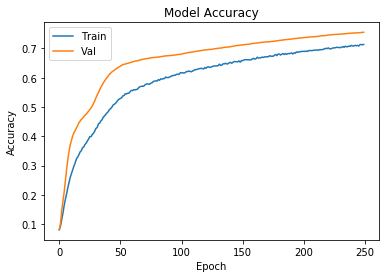

In [124]:
#incremento el dropout
#Parto del optimizador SGS y el inicializador random
model_final_LR2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR2.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR2.compile(optimizer=OPTIMIZER_LR2, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR2= model_final_LR2.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR2, title="Model Accuracy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               100480    
_________________________________________________________________
dropout_49 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 1s 19us/step - loss: 1.4451 - acc: 0.5425 - val_loss: 1.3394 - val_acc: 0.6386
Epoch 52/250
48000/48000 [==============================] - 1s 19us/step - loss: 1.4344 - acc: 0.5404 - val_loss: 1.3255 - val_acc: 0.6400
Epoch 53/250
48000/48000 [==============================] - 1s 18us/step - loss: 1.4205 - acc: 0.5469 - val_loss: 1.3117 - val_acc: 0.6417
Epoch 54/250
48000/48000 [==============================] - 1s 18us/step - loss: 1.4082 - acc: 0.5482 - val_loss: 1.2984 - val_acc: 0.6446
Epoch 55/250
48000/48000 [==============================] - 1s 18us/step - loss: 1.3978 - acc: 0.5505 - val_loss: 1.2854 - val_acc: 0.6467
Epoch 56/250
48000/48000 [==============================] - 1s 18us/step - loss: 1.3868 - acc: 0.5536 - val_loss: 1.2727 - val_acc: 0.6490
Epoch 57/250
48000/48000 [==============================] - 1s 18us/step - loss: 1.3721 - acc: 0.5564 - val_loss: 1.2602 - val_acc: 0.6516
Epoch 58/250
48000/48000 [==============

Epoch 110/250
48000/48000 [==============================] - 1s 19us/step - loss: 1.0325 - acc: 0.6391 - val_loss: 0.9015 - val_acc: 0.7106
Epoch 111/250
48000/48000 [==============================] - 1s 21us/step - loss: 1.0318 - acc: 0.6400 - val_loss: 0.8981 - val_acc: 0.7113
Epoch 112/250
48000/48000 [==============================] - 1s 18us/step - loss: 1.0260 - acc: 0.6410 - val_loss: 0.8947 - val_acc: 0.7113
Epoch 113/250
48000/48000 [==============================] - 1s 19us/step - loss: 1.0219 - acc: 0.6455 - val_loss: 0.8914 - val_acc: 0.7116
Epoch 114/250
48000/48000 [==============================] - 1s 19us/step - loss: 1.0166 - acc: 0.6438 - val_loss: 0.8881 - val_acc: 0.7129
Epoch 115/250
48000/48000 [==============================] - 1s 24us/step - loss: 1.0138 - acc: 0.6463 - val_loss: 0.8849 - val_acc: 0.7132
Epoch 116/250
48000/48000 [==============================] - 1s 22us/step - loss: 1.0093 - acc: 0.6469 - val_loss: 0.8817 - val_acc: 0.7139
Epoch 117/250
48000/

48000/48000 [==============================] - 1s 19us/step - loss: 0.8886 - acc: 0.6855 - val_loss: 0.7705 - val_acc: 0.7387
Epoch 169/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8888 - acc: 0.6855 - val_loss: 0.7691 - val_acc: 0.7395
Epoch 170/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8874 - acc: 0.6846 - val_loss: 0.7676 - val_acc: 0.7396
Epoch 171/250
48000/48000 [==============================] - 1s 18us/step - loss: 0.8870 - acc: 0.6878 - val_loss: 0.7662 - val_acc: 0.7397
Epoch 172/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8826 - acc: 0.6876 - val_loss: 0.7648 - val_acc: 0.7402
Epoch 173/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.8833 - acc: 0.6907 - val_loss: 0.7634 - val_acc: 0.7402
Epoch 174/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.8793 - acc: 0.6895 - val_loss: 0.7619 - val_acc: 0.7409
Epoch 175/250
48000/48000 [=======

48000/48000 [==============================] - 1s 23us/step - loss: 0.8123 - acc: 0.7152 - val_loss: 0.7043 - val_acc: 0.7568
Epoch 227/250
48000/48000 [==============================] - 1s 22us/step - loss: 0.8112 - acc: 0.7146 - val_loss: 0.7035 - val_acc: 0.7576
Epoch 228/250
48000/48000 [==============================] - 1s 20us/step - loss: 0.8094 - acc: 0.7156 - val_loss: 0.7026 - val_acc: 0.7581
Epoch 229/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8085 - acc: 0.7147 - val_loss: 0.7017 - val_acc: 0.7582
Epoch 230/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8059 - acc: 0.7153 - val_loss: 0.7008 - val_acc: 0.7588
Epoch 231/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8054 - acc: 0.7166 - val_loss: 0.7000 - val_acc: 0.7589
Epoch 232/250
48000/48000 [==============================] - 1s 19us/step - loss: 0.8075 - acc: 0.7179 - val_loss: 0.6991 - val_acc: 0.7588
Epoch 233/250
48000/48000 [=======

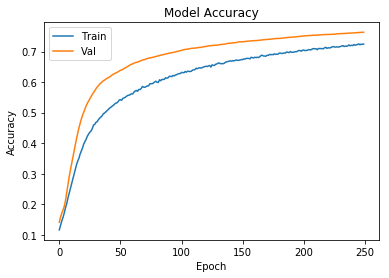

In [127]:
#incremento el dropout
#Parto del optimizador SGS y el inicializador random
model_final_LR3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR3.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR3.compile(optimizer=OPTIMIZER_LR3, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR3= model_final_LR3.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR3, title="Model Accuracy")

In [129]:
#modificación de las neuronas de la capa oculta, partiendo del mejor modelo anterior. 
#En los dos últimos casos, los modelo presentan overfitting con lo que selecciono el primero para modificar las 
#capas ocultas.
N_HIDDEN1=256
N_HIDDEN2=512
N_HIDDEN3=1024

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_27 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_51 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_52 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 2s 31us/step - loss: 0.3352 - acc: 0.8798 - val_loss: 0.3410 - val_acc: 0.8780
Epoch 52/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.3345 - acc: 0.8801 - val_loss: 0.3406 - val_acc: 0.8787
Epoch 53/250
48000/48000 [==============================] - 2s 31us/step - loss: 0.3346 - acc: 0.8807 - val_loss: 0.3398 - val_acc: 0.8802
Epoch 54/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.3326 - acc: 0.8810 - val_loss: 0.3385 - val_acc: 0.8787
Epoch 55/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.3304 - acc: 0.8815 - val_loss: 0.3357 - val_acc: 0.8799
Epoch 56/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.3286 - acc: 0.8824 - val_loss: 0.3362 - val_acc: 0.8816
Epoch 57/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3270 - acc: 0.8841 - val_loss: 0.3348 - val_acc: 0.8799
Epoch 58/250
48000/48000 [==============

Epoch 110/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.2629 - acc: 0.9069 - val_loss: 0.3041 - val_acc: 0.8908
Epoch 111/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.2635 - acc: 0.9060 - val_loss: 0.3059 - val_acc: 0.8889
Epoch 112/250
48000/48000 [==============================] - 2s 31us/step - loss: 0.2621 - acc: 0.9055 - val_loss: 0.3034 - val_acc: 0.8901
Epoch 113/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.2593 - acc: 0.9071 - val_loss: 0.3039 - val_acc: 0.8902
Epoch 114/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.2604 - acc: 0.9056 - val_loss: 0.3025 - val_acc: 0.8911
Epoch 115/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.2594 - acc: 0.9075 - val_loss: 0.3023 - val_acc: 0.8927
Epoch 116/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.2594 - acc: 0.9063 - val_loss: 0.3024 - val_acc: 0.8902
Epoch 117/250
48000/

48000/48000 [==============================] - 1s 31us/step - loss: 0.2177 - acc: 0.9218 - val_loss: 0.2932 - val_acc: 0.8957
Epoch 169/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.2128 - acc: 0.9236 - val_loss: 0.2938 - val_acc: 0.8938
Epoch 170/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.2153 - acc: 0.9220 - val_loss: 0.2931 - val_acc: 0.8948
Epoch 171/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.2134 - acc: 0.9225 - val_loss: 0.2935 - val_acc: 0.8961
Epoch 172/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.2119 - acc: 0.9232 - val_loss: 0.2945 - val_acc: 0.8932
Epoch 173/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.2137 - acc: 0.9229 - val_loss: 0.2922 - val_acc: 0.8949
Epoch 174/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.2095 - acc: 0.9237 - val_loss: 0.2949 - val_acc: 0.8938
Epoch 175/250
48000/48000 [=======

48000/48000 [==============================] - 2s 32us/step - loss: 0.1775 - acc: 0.9362 - val_loss: 0.2952 - val_acc: 0.8968
Epoch 227/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.1747 - acc: 0.9374 - val_loss: 0.2985 - val_acc: 0.8972
Epoch 228/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.1749 - acc: 0.9374 - val_loss: 0.2964 - val_acc: 0.8965
Epoch 229/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.1729 - acc: 0.9383 - val_loss: 0.2980 - val_acc: 0.8948
Epoch 230/250
48000/48000 [==============================] - 2s 32us/step - loss: 0.1734 - acc: 0.9371 - val_loss: 0.2946 - val_acc: 0.8969
Epoch 231/250
48000/48000 [==============================] - 1s 31us/step - loss: 0.1722 - acc: 0.9391 - val_loss: 0.2930 - val_acc: 0.8962
Epoch 232/250
48000/48000 [==============================] - 2s 31us/step - loss: 0.1721 - acc: 0.9385 - val_loss: 0.2965 - val_acc: 0.8963
Epoch 233/250
48000/48000 [=======

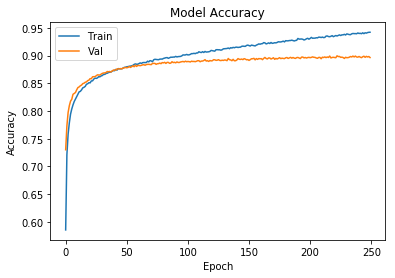

In [130]:
#incremento N_HIDDENa 256
#Parto del optimizador SGS y el inicializador random
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN1, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN1,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_35 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_98 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 2s 33us/step - loss: 0.3426 - acc: 0.8776 - val_loss: 0.3429 - val_acc: 0.8780
Epoch 52/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3389 - acc: 0.8796 - val_loss: 0.3419 - val_acc: 0.8786
Epoch 53/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3400 - acc: 0.8785 - val_loss: 0.3424 - val_acc: 0.8774
Epoch 54/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3365 - acc: 0.8799 - val_loss: 0.3404 - val_acc: 0.8785
Epoch 55/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3363 - acc: 0.8796 - val_loss: 0.3397 - val_acc: 0.8782
Epoch 56/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3337 - acc: 0.8807 - val_loss: 0.3384 - val_acc: 0.8782
Epoch 57/250
48000/48000 [==============================] - 2s 33us/step - loss: 0.3342 - acc: 0.8798 - val_loss: 0.3379 - val_acc: 0.8793
Epoch 58/250
48000/48000 [==============

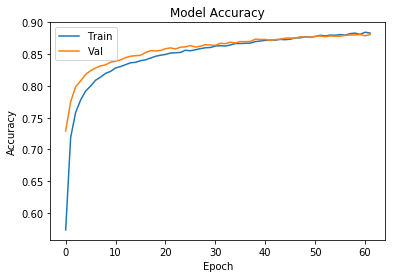

In [138]:
#Compruebo el modelo 1 con early stopping =2
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

#El argumento "patience" representa el número de épcas antes parar el proceso una vez que la loss comienza a
#incrementarse, lo que es igual a que el modelo para de realizar mejora
#Aqui está parametrizado a 2.
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN1, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN1,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE,callbacks=[earlyStopping],validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_28 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_53 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_54 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 2s 50us/step - loss: 0.3198 - acc: 0.8858 - val_loss: 0.3347 - val_acc: 0.8802
Epoch 52/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.3201 - acc: 0.8852 - val_loss: 0.3337 - val_acc: 0.8819
Epoch 53/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.3172 - acc: 0.8856 - val_loss: 0.3327 - val_acc: 0.8823
Epoch 54/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.3152 - acc: 0.8880 - val_loss: 0.3302 - val_acc: 0.8832
Epoch 55/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.3117 - acc: 0.8883 - val_loss: 0.3290 - val_acc: 0.8832
Epoch 56/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.3119 - acc: 0.8885 - val_loss: 0.3277 - val_acc: 0.8828
Epoch 57/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.3102 - acc: 0.8884 - val_loss: 0.3275 - val_acc: 0.8843
Epoch 58/250
48000/48000 [==============

Epoch 110/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.2414 - acc: 0.9141 - val_loss: 0.2991 - val_acc: 0.8946
Epoch 111/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.2397 - acc: 0.9141 - val_loss: 0.3002 - val_acc: 0.8912
Epoch 112/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.2382 - acc: 0.9151 - val_loss: 0.2972 - val_acc: 0.8941
Epoch 113/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.2378 - acc: 0.9151 - val_loss: 0.2971 - val_acc: 0.8947
Epoch 114/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.2368 - acc: 0.9145 - val_loss: 0.2975 - val_acc: 0.8952
Epoch 115/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.2363 - acc: 0.9163 - val_loss: 0.2997 - val_acc: 0.8934
Epoch 116/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.2354 - acc: 0.9153 - val_loss: 0.2969 - val_acc: 0.8950
Epoch 117/250
48000/

48000/48000 [==============================] - 2s 51us/step - loss: 0.1882 - acc: 0.9324 - val_loss: 0.2914 - val_acc: 0.8986
Epoch 169/250
48000/48000 [==============================] - 3s 52us/step - loss: 0.1841 - acc: 0.9335 - val_loss: 0.2933 - val_acc: 0.8972
Epoch 170/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1833 - acc: 0.9348 - val_loss: 0.2944 - val_acc: 0.8979
Epoch 171/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1831 - acc: 0.9349 - val_loss: 0.2905 - val_acc: 0.9001
Epoch 172/250
48000/48000 [==============================] - 2s 50us/step - loss: 0.1811 - acc: 0.9351 - val_loss: 0.2915 - val_acc: 0.8975
Epoch 173/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1834 - acc: 0.9355 - val_loss: 0.2924 - val_acc: 0.8976
Epoch 174/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1832 - acc: 0.9346 - val_loss: 0.2903 - val_acc: 0.8997
Epoch 175/250
48000/48000 [=======

48000/48000 [==============================] - 2s 51us/step - loss: 0.1428 - acc: 0.9500 - val_loss: 0.2963 - val_acc: 0.8995
Epoch 227/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1401 - acc: 0.9514 - val_loss: 0.2957 - val_acc: 0.9011
Epoch 228/250
48000/48000 [==============================] - 2s 52us/step - loss: 0.1396 - acc: 0.9510 - val_loss: 0.2951 - val_acc: 0.9000
Epoch 229/250
48000/48000 [==============================] - 2s 52us/step - loss: 0.1401 - acc: 0.9509 - val_loss: 0.2983 - val_acc: 0.8990
Epoch 230/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1385 - acc: 0.9516 - val_loss: 0.2985 - val_acc: 0.9006
Epoch 231/250
48000/48000 [==============================] - 2s 51us/step - loss: 0.1392 - acc: 0.9502 - val_loss: 0.3027 - val_acc: 0.8996
Epoch 232/250
48000/48000 [==============================] - 2s 52us/step - loss: 0.1372 - acc: 0.9522 - val_loss: 0.3016 - val_acc: 0.9004
Epoch 233/250
48000/48000 [=======

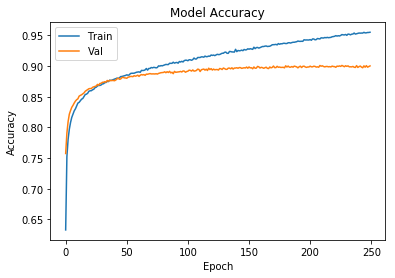

In [131]:
#para 256, se obtienes acc: 0.9421  val_acc: 0.8965
#Paso a valorar con 512
#incremento N_HIDDENa 256
#Parto del optimizador SGS y el inicializador random
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN2, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN2,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_65 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_66 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Trai

48000/48000 [==============================] - 3s 55us/step - loss: 0.3159 - acc: 0.8867 - val_loss: 0.3338 - val_acc: 0.8788
Epoch 52/250
48000/48000 [==============================] - 3s 56us/step - loss: 0.3117 - acc: 0.8881 - val_loss: 0.3300 - val_acc: 0.8814
Epoch 53/250
48000/48000 [==============================] - 3s 55us/step - loss: 0.3137 - acc: 0.8869 - val_loss: 0.3287 - val_acc: 0.8830
Epoch 54/250
48000/48000 [==============================] - 3s 54us/step - loss: 0.3115 - acc: 0.8881 - val_loss: 0.3295 - val_acc: 0.8806
Epoch 55/250
48000/48000 [==============================] - 3s 53us/step - loss: 0.3093 - acc: 0.8890 - val_loss: 0.3285 - val_acc: 0.8819
Epoch 56/250
48000/48000 [==============================] - 3s 53us/step - loss: 0.3092 - acc: 0.8886 - val_loss: 0.3263 - val_acc: 0.8815
Epoch 57/250
48000/48000 [==============================] - 3s 52us/step - loss: 0.3064 - acc: 0.8895 - val_loss: 0.3258 - val_acc: 0.8834
Epoch 58/250
48000/48000 [==============

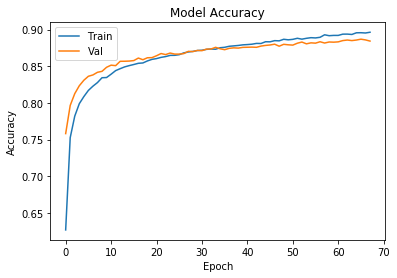

In [137]:

#Compruebo el modelo 2 con early stopping =2
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

#El argumento "patience" representa el número de épcas antes parar el proceso una vez que la loss comienza a
#incrementarse, lo que es igual a que el modelo para de realizar mejora
#Aqui está parametrizado a 2.
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN2, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN2,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE,callbacks=[earlyStopping],validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_29 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_80 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_55 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_81 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_56 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 10)                10250     
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
_________________________________________________________________


48000/48000 [==============================] - 6s 117us/step - loss: 0.2956 - acc: 0.8945 - val_loss: 0.3196 - val_acc: 0.8844
Epoch 52/250
48000/48000 [==============================] - 6s 116us/step - loss: 0.2919 - acc: 0.8946 - val_loss: 0.3196 - val_acc: 0.8867
Epoch 53/250
48000/48000 [==============================] - 6s 116us/step - loss: 0.2934 - acc: 0.8941 - val_loss: 0.3191 - val_acc: 0.8862
Epoch 54/250
48000/48000 [==============================] - 6s 121us/step - loss: 0.2898 - acc: 0.8959 - val_loss: 0.3180 - val_acc: 0.8849
Epoch 55/250
48000/48000 [==============================] - 6s 120us/step - loss: 0.2886 - acc: 0.8971 - val_loss: 0.3185 - val_acc: 0.8859
Epoch 56/250
48000/48000 [==============================] - 6s 123us/step - loss: 0.2844 - acc: 0.8982 - val_loss: 0.3154 - val_acc: 0.8870
Epoch 57/250
48000/48000 [==============================] - 6s 117us/step - loss: 0.2858 - acc: 0.8982 - val_loss: 0.3162 - val_acc: 0.8859
Epoch 58/250
48000/48000 [=======

48000/48000 [==============================] - 6s 115us/step - loss: 0.2128 - acc: 0.9242 - val_loss: 0.2899 - val_acc: 0.8956
Epoch 110/250
48000/48000 [==============================] - 6s 116us/step - loss: 0.2119 - acc: 0.9244 - val_loss: 0.2905 - val_acc: 0.8958
Epoch 111/250
48000/48000 [==============================] - 6s 118us/step - loss: 0.2129 - acc: 0.9247 - val_loss: 0.2924 - val_acc: 0.8945
Epoch 112/250
48000/48000 [==============================] - 6s 121us/step - loss: 0.2113 - acc: 0.9239 - val_loss: 0.2920 - val_acc: 0.8955
Epoch 113/250
48000/48000 [==============================] - 6s 119us/step - loss: 0.2096 - acc: 0.9252 - val_loss: 0.2903 - val_acc: 0.8951
Epoch 114/250
48000/48000 [==============================] - 6s 123us/step - loss: 0.2072 - acc: 0.9268 - val_loss: 0.2924 - val_acc: 0.8945
Epoch 115/250
48000/48000 [==============================] - 6s 127us/step - loss: 0.2075 - acc: 0.9251 - val_loss: 0.2901 - val_acc: 0.8937
Epoch 116/250
48000/48000 [

48000/48000 [==============================] - 6s 120us/step - loss: 0.1564 - acc: 0.9454 - val_loss: 0.2864 - val_acc: 0.9007
Epoch 168/250
48000/48000 [==============================] - 6s 121us/step - loss: 0.1548 - acc: 0.9461 - val_loss: 0.2868 - val_acc: 0.8997
Epoch 169/250
48000/48000 [==============================] - 6s 119us/step - loss: 0.1552 - acc: 0.9449 - val_loss: 0.2873 - val_acc: 0.9004
Epoch 170/250
48000/48000 [==============================] - 6s 118us/step - loss: 0.1539 - acc: 0.9456 - val_loss: 0.2858 - val_acc: 0.8994
Epoch 171/250
48000/48000 [==============================] - 6s 118us/step - loss: 0.1519 - acc: 0.9465 - val_loss: 0.2902 - val_acc: 0.8993
Epoch 172/250
48000/48000 [==============================] - 6s 118us/step - loss: 0.1521 - acc: 0.9467 - val_loss: 0.2924 - val_acc: 0.8992
Epoch 173/250
48000/48000 [==============================] - 6s 119us/step - loss: 0.1494 - acc: 0.9464 - val_loss: 0.2888 - val_acc: 0.8996
Epoch 174/250
48000/48000 [

48000/48000 [==============================] - 6s 118us/step - loss: 0.1120 - acc: 0.9612 - val_loss: 0.2966 - val_acc: 0.9013
Epoch 226/250
48000/48000 [==============================] - 6s 121us/step - loss: 0.1095 - acc: 0.9633 - val_loss: 0.2995 - val_acc: 0.9002
Epoch 227/250
48000/48000 [==============================] - 6s 115us/step - loss: 0.1106 - acc: 0.9620 - val_loss: 0.3012 - val_acc: 0.9017
Epoch 228/250
48000/48000 [==============================] - 6s 117us/step - loss: 0.1104 - acc: 0.9626 - val_loss: 0.3050 - val_acc: 0.8992
Epoch 229/250
48000/48000 [==============================] - 6s 119us/step - loss: 0.1092 - acc: 0.9629 - val_loss: 0.2992 - val_acc: 0.9000
Epoch 230/250
48000/48000 [==============================] - 6s 124us/step - loss: 0.1078 - acc: 0.9630 - val_loss: 0.3013 - val_acc: 0.9009
Epoch 231/250
48000/48000 [==============================] - 6s 122us/step - loss: 0.1088 - acc: 0.9629 - val_loss: 0.2999 - val_acc: 0.9018
Epoch 232/250
48000/48000 [

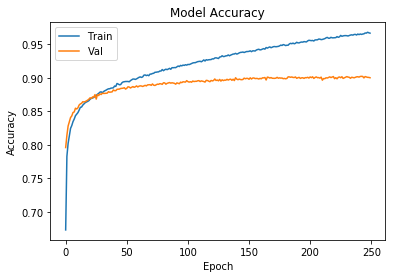

In [132]:
#Para 512, acc: 0.9552  - val_acc: 0.9003

#Paso a valorar con 1024
#Parto del optimizador SGS y el inicializador random
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN3, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN3,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_63 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_64 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 10)                10250     
Total params: 1,863,690
Trainable params: 1,863,690
Non-trainable params: 0
_________________________________________________________________


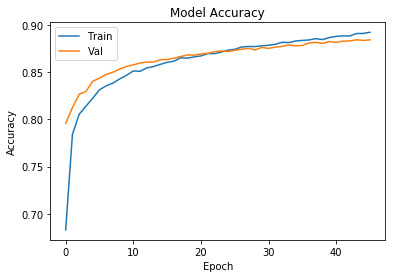

In [136]:
#Compruebo el early sttoping con el mejor de los tres anteriores: este parámetros basciamente para el proceso de training
# una vez que el parámetros comienza a incrementartse. En otras palabras, la "validations accuracy" comienza a decrecer
#Obviamente, cuantas más neuronas tenga, mejores van a ser los resultados.
#Para el tercer modelo, acc: 0.9666 - val_acc: 0.9002


earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

#El argumento "patience" representa el número de épcas antes parar el proceso una vez que la loss comienza a
#incrementarse, lo que es igual a que el modelo para de realizar mejora
#Aqui está parametrizado a 2.
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN3, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN3,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE,callbacks=[earlyStopping],validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")



##### Análisis de los modelos estudiados en la  Regularización 
* Finalmente, de todos los modelos estudiados, llegamos a la conclusión de que la mejor opción es:
    * Dropout=30% (estudiados adicionalmente, 20% y 40%)
    * Optmizador = SGD (Estudiados adicionalemtne, ADAM y RMSprop)
    * Inicializador=random (Estudiados adicionalemente, Zeros y glorot_uniform)
    * LR=0.01 (estudiados adicionamente: LR=0.001 y LR=0.0001)
* A partir de aquí, he variado el número de neuronas de las capas internas (2)
    * N_HIDDEN1=255:  acc: 0.9421 -  val_acc: 0.8965
    * N_HIDDEN2=512:  acc: 0.9552 -  val_acc: 0.9003
    * N_HIDDEN3=1024: acc: 0.9666 -  val_acc: 0.9002
* Puesto que para N_HIDDEN3 y N_HIDDEN2, los tiempos de ejecución son elevados, he aplicado el parámetro early sttoping. Este parámetro básicamente para el proceso de training una vez que el parámetros loss comienza a incrementartse. En otras palabras, la "validations accuracy" comienza a decrecer.
* Así, los valores obtenidos para:
    * N_HIDDEN1=256:
        * Eppochs:62
        * Acc: 88,31%
        * Val_acc:88,07%
    * N_HIDDEN2=512:  
        * Eppochs:68
        * Acc: 89,64%
        * Val_acc: 88,43%
    * N_HIDDEN3=1024: 
        * Eppochs:46
        * Acc:89,21% 
        * Val_acc:acc:88,41%
* A partir de los datos anteriores, nos quedaríamos con el modelo de 512 neuronas en las capas ocultas y con un número de épocas de 68

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_36 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 512)               401920    
_________________________________________________________________
dropout_69 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_70 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Trai

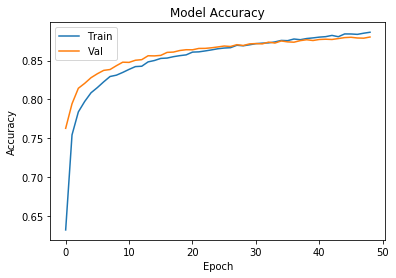

In [139]:
#Compruebo el modelo 2 con early stopping =2
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

#El argumento "patience" representa el número de épcas antes parar el proceso una vez que la loss comienza a
#incrementarse, lo que es igual a que el modelo para de realizar mejora
#Aqui está parametrizado a 2.
model_final_LR1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(N_HIDDEN2, activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(N_HIDDEN2,  activation=tf.nn.relu,kernel_initializer='random_normal'),
    keras.layers.Dropout(DROPOUT2),
    keras.layers.Dense(NB_CLASSES,activation=tf.nn.softmax)
])
model_final_LR1.summary()
#Compilo el modelo CON EL OPTIMIZADOR SGD
model_final_LR1.compile(optimizer=OPTIMIZER_LR1, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_final_LR1= model_final_LR1.fit(x_train, y_train,batch_size=BATCH_SIZE, 
                   epochs=NB_EPOCH,verbose=VERBOSE,callbacks=[earlyStopping],validation_split=VALIDATION_SPLIT)
#muestro la accuracy del modelo
plot_acc(history_final_LR1, title="Model Accuracy")


In [140]:
#En este caso, las épocas de entrenamiento se han reducido frente al caso de estudio (49-->68)
#acc: 0.8863  val_acc: 0.8802
test_loss_final, test_acc_final = model_final_LR1.evaluate(x_test, y_test)

print('Test accuracy:', test_loss_final)
print('Test loss:', test_acc_final)

10000/10000 [==============================] - 0s 44us/step
Test accuracy: 0.36162660031318666
Test loss: 0.8704


In [181]:
#Realizo la predicción
### Tu código aquí ###
predictions = model_final_LR1.predict(x_test)
predictions[25]

array([2.6466064e-03, 2.0613571e-04, 7.9579419e-01, 1.4046460e-03,
       1.3404736e-01, 1.0061008e-04, 6.5209925e-02, 2.5244030e-05,
       5.3545146e-04, 2.9904444e-05], dtype=float32)

In [182]:
# Librerias añadidas
import numpy as np
np.argmax(predictions[25])

2

In [183]:
y_test[25]

4

In [185]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names[4]

'Coat'

In [186]:
predictions[1]

array([1.22621597e-04, 1.64529339e-07, 9.95335400e-01, 5.12213228e-06,
       1.55822455e-03, 4.54024063e-09, 2.97707343e-03, 1.22575985e-08,
       1.28456088e-06, 5.14139220e-09], dtype=float32)

In [187]:
np.argmax(predictions[1])

2

In [188]:
y_test[1]

2

In [189]:
class_names[2]

'Pullover'

In [190]:
#Se puede hacer un plotting para las 10 clase que existen
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

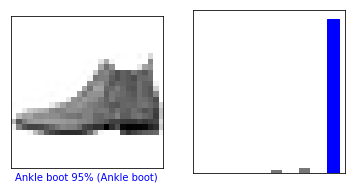

In [191]:
#Si observamos la imagen 0 
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test)

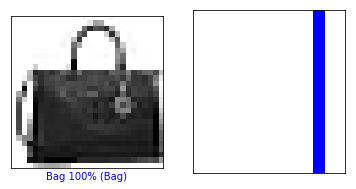

In [192]:
i = 30
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test)


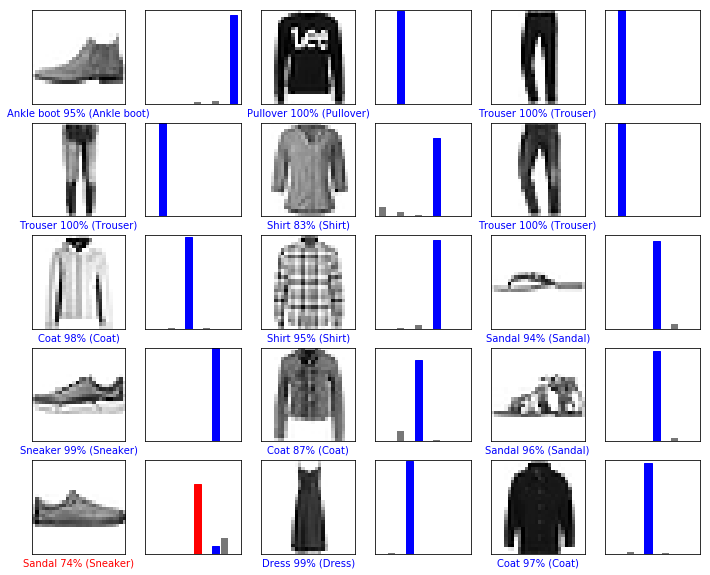

In [193]:
#Se hace un plottting de las 15 primeras imagenes del dataset y sus predicciones y la etiqueta correcta.
#El color azul es para las predicciones correctas y el rojo para las incorrectas.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test)


In [198]:
#Finalmente, utilizando el modelo entrenado para hacer una predicción sobre una única imagen.
# Tomo una imagen del conjunto de datos de prueba
img = x_test[25]

print(img.shape)

(28, 28)


In [199]:
# Añador la imagen al batch, donde éste tendrá un único elementoA
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [200]:
predictions_single = model_final_LR1.predict(img)

print(predictions_single)

[[2.64660479e-03 2.06135679e-04 7.95794070e-01 1.40464574e-03
  1.34047270e-01 1.00610065e-04 6.52099699e-02 2.52440495e-05
  5.35450876e-04 2.99044095e-05]]


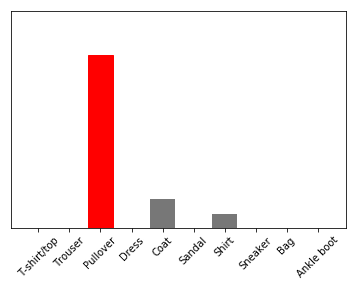

In [201]:
plot_value_array(0, predictions_single, y_test)
_ = plt.xticks(range(10), class_names, rotation=45)

In [175]:
#model_final_LR1.predict una lista, una por cada imagen en el batch de datos
#Grab the predictions for our (only) image in the batch

In [202]:
np.argmax(predictions_single[0])

2

In [203]:
class_names[2]

'Pullover'

In [204]:
y_test[25]

4

In [ ]:
#Realiza la misma predicción que anteriormente, la predicción dice que la imagen es un jersey, 
#cuando realmente es un abrigo

In [205]:
class_names[4]

'Coat'